# 1. Написать приложение, которое собирает основные новости с сайта на выбор news.mail.ru, lenta.ru, yandex-новости. Для парсинга использовать XPath. Структура данных должна содержать:
## *  название источника;
## *  наименование новости;
## * ссылку на новость;
## * дата публикации.
# 2. Сложить собранные новости в БД

In [56]:
import re
import requests
import matplotlib.pyplot as plt
import datetime
from hashlib import md5
from PIL import Image
from pprint import pprint
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError
from lxml import html

%matplotlib inline

In [57]:
client = MongoClient('127.0.0.1', 27017)
db = client['news']

collection = db.news

## Lenta
### Ниже показано, как выглядит новостная лента на сайте Lenta.ru
### Нам нужно отдельно обработать главную новость и 12 остальных

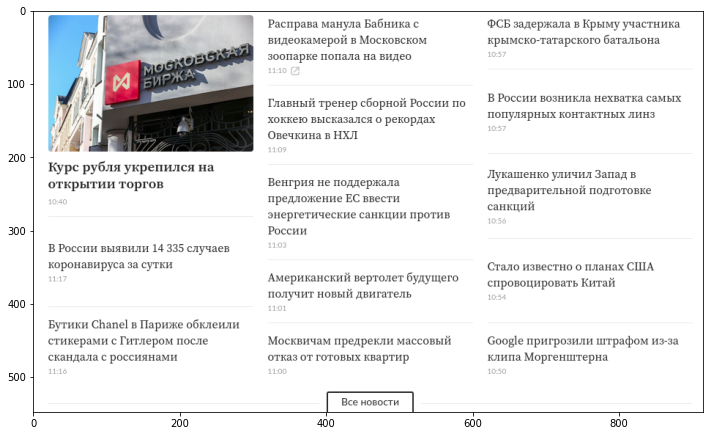

In [58]:
img = Image.open('./img/lenta.png')

plt.figure(figsize=(12, 10))
plt.imshow(img)

In [59]:
lenta_url = 'https://lenta.ru'

headers = {'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.174 YaBrowser/22.1.3.907 (beta) Yowser/2.5 Safari/537.36'}

response = requests.get(lenta_url, headers=headers)

lenta_dom = html.fromstring(response.text)

### Так как для каждой новости мы будем переходить на новую страницу, я создам функцию, генерирующию словарь с нужными данными
### Так же используем хэширование словаря для генерации его индека, это позволит нам избавиться от дубликатов, но при сборе из разных сайтов одинаковые новости будут записываться по разному, так что это не полное решение проблемы

In [60]:
def lenta_insert_dict(dom, href):
    insert_dict = {}
    
    insert_dict['source_name'] = dom.xpath('//a[@class="topic-header__item topic-header__rubric"]/text()')[0]
    insert_dict['title'] = dom.xpath('//span[@class="topic-body__title"]/text()')[0]
    insert_dict['href'] = href
    insert_dict['time_news_add'] = dom.xpath('//time[@class="topic-header__item topic-header__time"]/text()')[0]
    insert_dict['website'] = 'https://lenta.ru'
    
    hash_id = md5(str(insert_dict).encode('utf-8')).hexdigest()
    insert_dict['_id'] = hash_id
    
    # Также добавим колонку с текущим временем, что бы можно было ориентироваться во времени публикации
    # новости, так как время, зачастую, пишут не полностью
    insert_dict['datetime_insert'] = str( datetime.datetime.now() )
    
    return insert_dict


def moslenta_insert_dict(dom, href):
    insert_dict = {}
    
    insert_dict['source_name'] = dom.xpath('//div[contains(@class, "topic-text-wrap")]/div/div/a/span/text()')[0]
    insert_dict['title'] = dom.xpath('//h1[contains(@class, "title")]/text()')[0]
    insert_dict['href'] = href
    insert_dict['time_news_add'] = dom.xpath('//div[contains(@class, "topic-text-wrap")]/div/div[2]/text()')[0]
    insert_dict['website'] = 'https://moslenta.ru'

    hash_id = md5(str(insert_dict).encode('utf-8')).hexdigest()
    insert_dict['_id'] = hash_id

    # Также добавим колонку с текущим временем, что бы можно было ориентироваться во времени публикации
    # новости, так как время, зачастую, пишут не полностью
    insert_dict['datetime_insert'] = str( datetime.datetime.now() )
    
    return insert_dict

In [61]:
# Обработка главной новости
general_news = lenta_dom.xpath('//div[@class="topnews__first-topic"]')

# Переходим по ссылке на страницу новости
gen_news_href = lenta_dom.xpath('//div[@class="topnews__first-topic"]/a/@href')[0]
if 'http' not in gen_news_href:
    gen_news_href = lenta_url + gen_news_href

response_gen_news = requests.get(gen_news_href, headers=headers)

# Создаем XPath dom
lenta_dom_gen_news = html.fromstring(response_gen_news.text)

# Генерируем документ для ввода в базу данных
if 'https://moslenta.ru' in gen_news_href:
    insert_dict = moslenta_insert_dict(lenta_dom_gen_news, gen_news_href)
else:
    insert_dict = lenta_insert_dict(lenta_dom_gen_news, gen_news_href)

# Добавляем документ в базу данных
try:
    collection.insert_one(insert_dict)
except DuplicateKeyError:
    None

    
    
# Обработка остальных новостей
news_columns = lenta_dom.xpath('//div[@class="topnews__column"]')

for news_column in news_columns:
    for news_href in news_column.xpath('./a/@href'):
        # Переходим по ссылке на страницу новости
        if 'http' not in news_href:
            news_href = lenta_url + news_href
        
        response_news = requests.get(news_href, headers=headers)
        
        # Создаем XPath dom
        lenta_dom_news = html.fromstring(response_news.text)
        
        # Генерируем документ для ввода в базу данных
        if 'https://moslenta.ru' in news_href:
            insert_dict = moslenta_insert_dict(lenta_dom_news, news_href)
        else:
            insert_dict = lenta_insert_dict(lenta_dom_news, news_href)
            
        # Добавляем документ в базу данных
        try:
            collection.insert_one(insert_dict)
        except DuplicateKeyError:
            None

In [62]:
for news in collection.find({'$or': 
                             [{'website': 'https://lenta.ru'}, 
                              {'website': 'https://moslenta.ru'}]})[:3]:
    print()
    pprint(news)


{'_id': '85837c2a4883c3c3d3333c160135d85b',
 'datetime_insert': '2022-04-08 01:49:54.151628',
 'href': 'https://lenta.ru/news/2022/04/08/es/',
 'source_name': 'Экономика',
 'time_news_add': '00:53, 8 апреля 2022',
 'title': 'Страны Евросоюза согласовали пятый пакет антироссийских санкций',
 'website': 'https://lenta.ru'}

{'_id': '6ff4657b143d65726adfeaaa076a13d5',
 'datetime_insert': '2022-04-08 01:49:54.258059',
 'href': 'https://lenta.ru/news/2022/04/08/krisis/',
 'source_name': 'Экономика',
 'time_news_add': '01:30, 8 апреля 2022',
 'title': 'Описаны пять стратегий россиян в кризис',
 'website': 'https://lenta.ru'}

{'_id': '5ac9c3f7b774d253ca5ff921e341acc5',
 'datetime_insert': '2022-04-08 01:49:54.353115',
 'href': 'https://lenta.ru/news/2022/04/08/belgrad/',
 'source_name': 'Мир',
 'time_news_add': '01:30, 8 апреля 2022',
 'title': 'Вучич заявил о риске прекращения пути Сербии в Евросоюз из-за '
          'поддержки России',
 'website': 'https://lenta.ru'}


## Mail
### А вот, как выглядят новости в mail
### По такой же схеме выделяем главную и несколько остальных

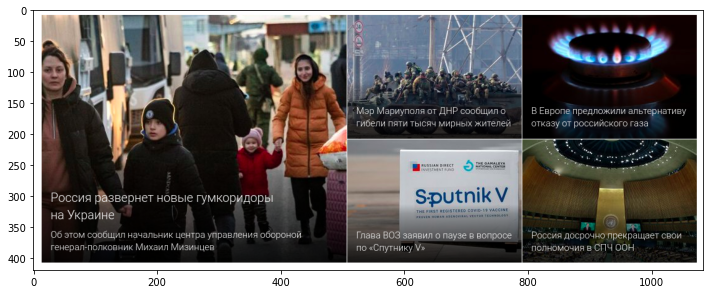

In [63]:
img = Image.open('./img/mail.png')

plt.figure(figsize=(12, 10))
plt.imshow(img)

In [64]:
mail_url = 'https://news.mail.ru'

headers = {'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.174 YaBrowser/22.1.3.907 (beta) Yowser/2.5 Safari/537.36'}

response = requests.get(mail_url, headers=headers)

mail_dom = html.fromstring(response.text)

### Содадим такие же функции, как для ленты

In [65]:
def mail_insert_dict(dom, href):
    insert_dict = {}
    
    insert_dict['source_name'] = dom.xpath('.//div[contains(@class, "breadcrumbs")]/span[2]/span/a/span/text()')[0]
    insert_dict['title'] = dom.xpath('.//h1[@class="hdr__inner"]/text()')[0]
    insert_dict['href'] = href
    insert_dict['time_news_add'] = dom.xpath('.//div[contains(@class, "breadcrumbs")]/span[1]/span/span/text()')[0]
    insert_dict['website'] = 'https://news.mail.ru'
    
    hash_id = md5(str(insert_dict).encode('utf-8')).hexdigest()
    insert_dict['_id'] = hash_id
    
    insert_dict['datetime_insert'] = str( datetime.datetime.now() )
    
    return insert_dict

In [66]:
# Обработка главной новости
gen_news_href = mail_dom.xpath('.//td[@class="daynews__main"]/div/a/@href')[0]

if 'http' not in gen_news_href:
    gen_news_href = mail_url + gen_news_href

response_gen_news = requests.get(gen_news_href, headers=headers)

# Создаем XPath dom
mail_dom_gen_news = html.fromstring(response_gen_news.text)

# Генерируем документ для ввода в базу данных
insert_dict = mail_insert_dict(mail_dom_gen_news, gen_news_href)

# Добавляем документ в базу данных
try:
    collection.insert_one(insert_dict)
except DuplicateKeyError:
    None



# Обработка остальных новостей
news_href_all = mail_dom.xpath('.//td[@class="daynews__items"]/div/a/@href')

for news_href in news_href_all:
    # Переходим по ссылке на страницу новости
    if 'http' not in news_href:
        news_href = lenta_url + news_href

    response_news = requests.get(news_href, headers=headers)

    # Создаем XPath dom
    mail_dom_news = html.fromstring(response_news.text)

    # Генерируем документ для ввода в базу данных
    insert_dict = mail_insert_dict(mail_dom_news, news_href)

    # Добавляем документ в базу данных
    try:
        collection.insert_one(insert_dict)
    except DuplicateKeyError:
        None

In [67]:
for news in collection.find({'website': 'https://news.mail.ru'})[:3]:
    print()
    pprint(news)


{'_id': 'a0b02aacf6575f970a29eb89d0c9a901',
 'datetime_insert': '2022-04-08 01:50:02.834046',
 'href': 'https://news.mail.ru/politics/50793501/',
 'source_name': '© РИА Новости',
 'time_news_add': '7 апреля',
 'title': 'Россия готова развернуть гумкоридоры на Украине на любых '
          'направлениях',
 'website': 'https://news.mail.ru'}

{'_id': '8683aea452b2f72bba8abaccc8191096',
 'datetime_insert': '2022-04-08 01:50:02.953564',
 'href': 'https://news.mail.ru/economics/50792569/',
 'source_name': 'Lenta.Ru',
 'time_news_add': '7 апреля',
 'title': 'В Европе предложили альтернативу отказу от российского газа',
 'website': 'https://news.mail.ru'}

{'_id': 'a514fecc5a04d58c16b17aec97f401c2',
 'datetime_insert': '2022-04-08 01:50:03.047846',
 'href': 'https://news.mail.ru/politics/50793909/',
 'source_name': 'ТАСС',
 'time_news_add': '00:04 (мск)',
 'title': 'Вучич: Сербии угрожает введение жестких санкций и прекращение пути '
          'в ЕС за отношения с РФ',
 'website': 'https://ne

## Yandex News
### Яндекс, в свою очередь, имеет более удобный для нас вид
### Так как вся нужная нам информация находится на главной странице, нам не придется переходить на страницу каждой новости
### Также яндекс новости устроены так, что страница разделена на большое количество секцый с разными категориями, к примеру в самом верху находится секция с главными новостями, ниже московские новости, еще ниже новости с категорией "интересное"
### Так как эта программа для изучения API, я не буду собирать новости со всех секций, а соберу только с первой, ибо пройтись по остальным новостям через цикл очень просто, мне не нужно в этом практиковаться

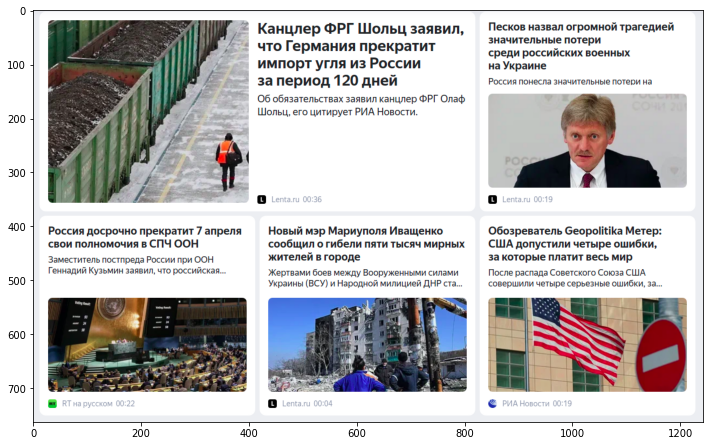

In [68]:
img = Image.open('./img/yandex.png')

plt.figure(figsize=(12, 10))
plt.imshow(img)

In [69]:
yandex_url = 'https://yandex.ru/news'

headers = {'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.174 YaBrowser/22.1.3.907 (beta) Yowser/2.5 Safari/537.36'}

response = requests.get(yandex_url, headers=headers)

yandex_dom = html.fromstring(response.text)

In [70]:
def yandex_insert_dict_main(dom):
    insert_dict = {}
    
    insert_dict['source_name'] = dom.xpath('.//span[@class="mg-card-source__time"]/text()')[0]
    insert_dict['title'] = dom.xpath('./div/div[2]/h2/a/text()')[0]
    insert_dict['href'] = dom.xpath('./div/div[2]/h2/a/@href')[0]
    insert_dict['time_news_add'] = dom.xpath('.//a[@class="mg-card__source-link"]/text()')[0]
    insert_dict['website'] = 'https://yandex.ru/news'
    
    hash_id = md5(str(insert_dict).encode('utf-8')).hexdigest()
    insert_dict['_id'] = hash_id
    
    insert_dict['datetime_insert'] = str( datetime.datetime.now() )
    
    return insert_dict


def yandex_insert_dict(dom):
    insert_dict = {}
    
    insert_dict['source_name'] = dom.xpath('.//div[@class="mg-card-footer__left"]/div/span[1]/a/text()')[0]
    insert_dict['title'] = dom.xpath('.//h2[@class="mg-card__title"]/a/text()')[0]
    insert_dict['href'] = dom.xpath('.//h2[@class="mg-card__title"]/a/@href')[0]
    insert_dict['time_news_add'] = dom.xpath('.//div[@class="mg-card-footer__left"]/div/span[2]/text()')[0]
    insert_dict['website'] = 'https://yandex.ru/news'
    
    hash_id = md5(str(insert_dict).encode('utf-8')).hexdigest()
    insert_dict['_id'] = hash_id
    
    insert_dict['datetime_insert'] = str( datetime.datetime.now() )
    
    return insert_dict

In [71]:
# Создаем dom нужной секции
section_dom = yandex_dom.xpath('.//section[@aria-labelledby="top-heading"]')[0]

# Генерируем документ главной новости для ввода в базу данных
news_dom = section_dom.xpath('./div/div[1]')[0]
insert_dict = yandex_insert_dict_main(news_dom)

# Добавляем документ в базу данных
try:
    collection.insert_one(insert_dict)
except DuplicateKeyError:
    None


# Обработка остальных новостей
for i in range(1, 6):
    # Создаем XPath dom нужной новости
    news_dom = section_dom.xpath(f'./div/div[{i}]')[0]

    # Генерируем документ для ввода в базу данных
    insert_dict = yandex_insert_dict(news_dom)

    # Добавляем документ в базу данных
    try:
        collection.insert_one(insert_dict)
    except DuplicateKeyError:
        None

In [72]:
for news in collection.find({'website': 'https://yandex.ru/news'})[:3]:
    print()
    pprint(news)


{'_id': '638e089620fc25ea14326e4f91835227',
 'datetime_insert': '2022-04-08 01:41:36.795257',
 'href': 'https://yandex.ru/news/story/Rossiya_dosrochno_prekratit_7_aprelya_svoi_polnomochiya_vSPCH_OON--7d93aa9ab09ed2fa838f184aabee7b1d?lang=ru&rubric=index&fan=1&stid=cwutTpnWOV722MUPieFA&t=1649370647&tt=true&persistent_id=191842735&story=d18c36ad-a8ac-5f90-9ccd-5e5e7f891324',
 'source_name': '00:22',
 'time_news_add': 'RT на русском',
 'title': 'Россия досрочно прекратит 7 апреля свои полномочия в\xa0СПЧ ООН',
 'website': 'https://yandex.ru/news'}

{'_id': '5690fb802a040f4430589d2c88cef1e8',
 'datetime_insert': '2022-04-08 01:41:36.954758',
 'href': 'https://yandex.ru/news/story/Rossiya_dosrochno_prekratit_7_aprelya_svoi_polnomochiya_vSPCH_OON--7d93aa9ab09ed2fa838f184aabee7b1d?lang=ru&rubric=index&fan=1&stid=cwutTpnWOV722MUPieFA&t=1649370647&tt=true&persistent_id=191842735&story=d18c36ad-a8ac-5f90-9ccd-5e5e7f891324',
 'source_name': 'RT на русском',
 'time_news_add': '00:22',
 'title': '